<a href="https://colab.research.google.com/github/recogru/papers/blob/master/TFRecord_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Пример работы с TFRecord для задачи сегментации

In [2]:
import numpy as np 
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random


In [11]:
# Создать данные для помещения в  записи
count_records = 100
images = []
random.seed(0)
for i in range(count_records):
  img = np.zeros((512,512,3),dtype=np.uint8)
  circles = random.randint(0,7) # от 0 до 7 окружностей
  for j in range(circles):
    x = random.randint(0,511)
    y = random.randint(0,511)
    r = random.randint(50,200)
    img = cv2.circle(img, (x,y), r, 255, -1)
  images.append(img)

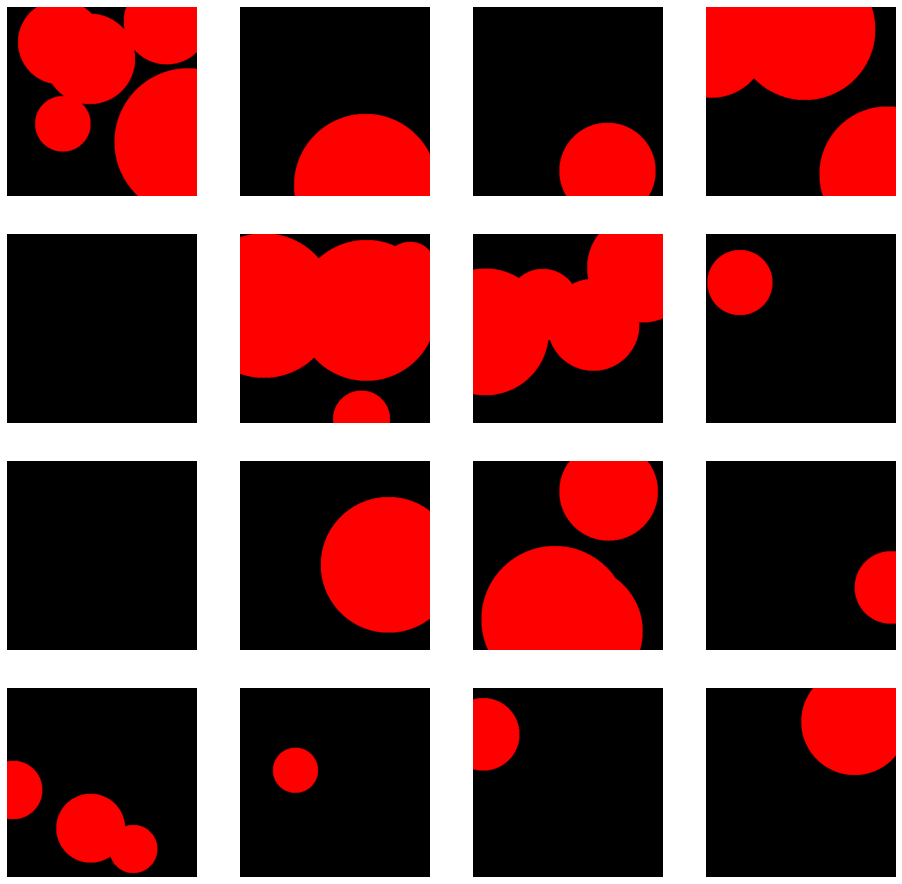

In [12]:
# Вывод изображений
columns, rows = 4,4
fig=plt.figure(figsize=(columns*4, rows*4))
for i in range(rows):
  for j in range(columns):
    idx = j+i*columns
    fig.add_subplot(rows, columns, j+i*columns+1)
    plt.axis('off')
    plt.imshow(Image.fromarray(images[idx]))            
plt.show()

In [17]:
# Создать маски для изображений
masks=[]
for img in images:
  im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret,im = cv2.threshold(im,1,1,cv2.THRESH_BINARY)
  masks.append(im)

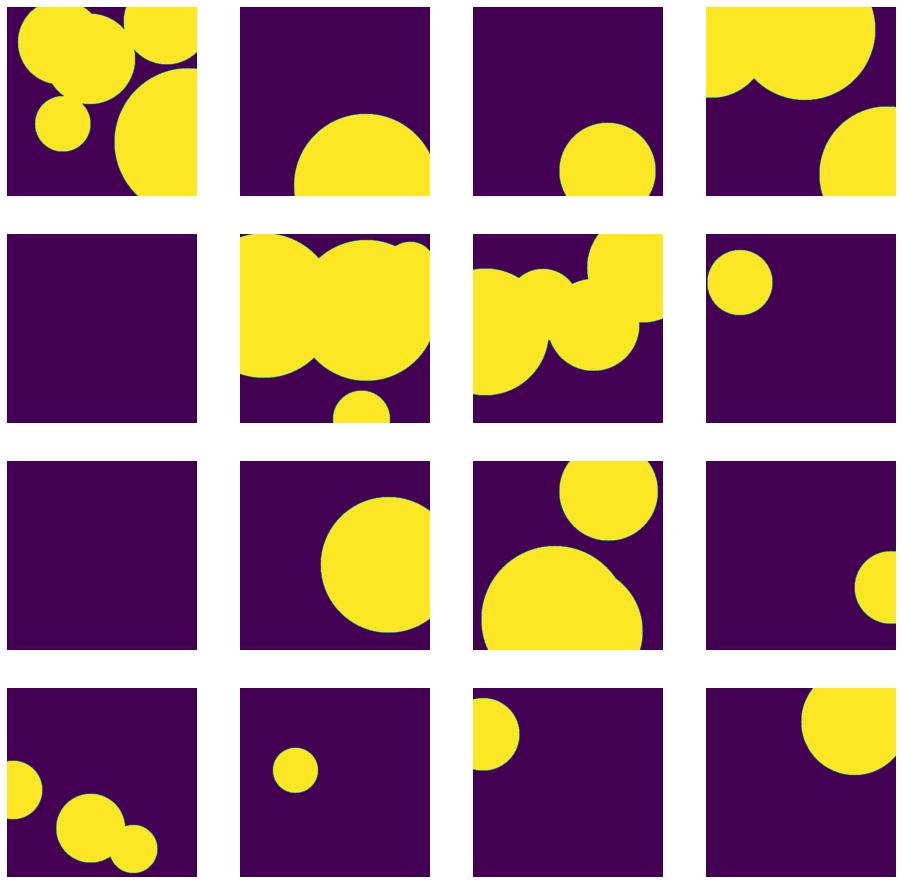

In [18]:
# Вывод масок
columns, rows = 4,4
fig=plt.figure(figsize=(columns*4, rows*4))
for i in range(rows):
  for j in range(columns):
    idx = j+i*columns
    fig.add_subplot(rows, columns, j+i*columns+1)
    plt.axis('off')
    plt.imshow(Image.fromarray(masks[idx]))            
plt.show()

In [19]:
import tensorflow as tf

In [20]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [21]:
def serialize_example(image, mask):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'image': _bytes_feature(image),
      'mask': _bytes_feature(mask),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [22]:
# Создать tfrec (помните, что оптимальный размер не больше 200Mb)
filename = 'test.tfrec'
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(count_records):
    example = serialize_example(images[i].tobytes(),masks[i].tobytes())
    writer.write(example)  

In [23]:
!ls -la

total 102428
drwxr-xr-x 1 root root      4096 Jan  5 11:00 .
drwxr-xr-x 1 root root      4096 Jan  5 10:36 ..
drwxr-xr-x 1 root root      4096 Dec 21 17:29 .config
drwxr-xr-x 1 root root      4096 Dec 21 17:29 sample_data
-rw-r--r-- 1 root root 104864100 Jan  5 11:00 test.tfrec


In [28]:
TRAINING_FILENAMES =[filename]
AUTO = -1
BATCH_SIZE = 4

In [31]:
# Для тестирования прочитать данные из tfrec
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'mask': tf.io.FixedLenFeature([], tf.string)
}
def _parse_image_function(example_proto):
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape( tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (512, 512, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'),(512, 512,1))
    return image,mask# tf.cast(image, tf.float32), tf.cast(mask, tf.float32) # cast as float32 required for TPU

def load_dataset(filenames, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(_parse_image_function, num_parallel_calls=AUTO)
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(128)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [32]:
for img, mask in get_training_dataset().take(1):
    pass

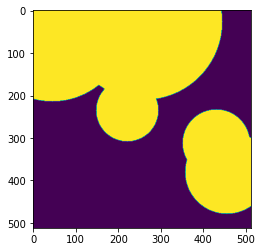

In [35]:
plt.imshow(mask[1].numpy().squeeze())

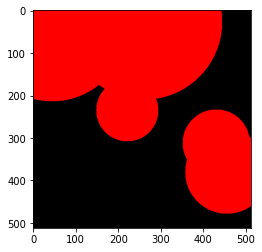

In [36]:
plt.imshow(img[1].numpy().squeeze())